In [1]:
import os
from torch.utils import data
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from utils import generate_data_list, SdDataset
from net import SKAttentionSwin_T

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

data_root = "/home/lym/桌面/gzr-lym/dataset"
classes_list = ['0', '1']
model_name = "skattention_swin_transformer"
BATCH_SIZE = 4

# 读取训练数据路径，验证数据路径
train_image_path_list, train_label_list = generate_data_list(data_root, classes_list, mode="train")
val_image_path_list, val_label_list = generate_data_list(data_root, classes_list, mode="test")

train_dataset = SdDataset(train_image_path_list, train_label_list, transform)
val_dataset = SdDataset(val_image_path_list, val_label_list, transform)

train_dl = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)  # 训练集标签
test_dl = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)  # 测试集标签



/home/lym/anaconda3/envs/pytorch-py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

/home/lym/桌面/gzr-lym/net/skattention_swin_transformer.py:173: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = F.softmax(attn)  # softmax(QKT/dk + B)


Epoch-1-Batch-5: Train: Loss-0.4147, Accuracy-0.2500
Epoch-1-Batch-10: Train: Loss-0.4273, Accuracy-0.3500
Epoch-1-Batch-15: Train: Loss-0.3630, Accuracy-0.3667
Epoch-1-Batch-20: Train: Loss-0.3278, Accuracy-0.3375
Epoch-1-Batch-25: Train: Loss-0.3156, Accuracy-0.3600
Epoch-1-Batch-30: Train: Loss-0.2905, Accuracy-0.3833
Epoch-1-Batch-35: Train: Loss-0.2735, Accuracy-0.4357
Epoch-1-Batch-40: Train: Loss-0.2734, Accuracy-0.4250
Epoch-1-Batch-45: Train: Loss-0.2629, Accuracy-0.4389
Epoch-1-Batch-50: Train: Loss-0.2531, Accuracy-0.4550
Epoch-1-Test Accurancy: 0.591 

Saving..
Epoch-2-Batch-5: Train: Loss-0.1705, Accuracy-0.6500
Epoch-2-Batch-10: Train: Loss-0.1770, Accuracy-0.6500
Epoch-2-Batch-15: Train: Loss-0.1782, Accuracy-0.6000
Epoch-2-Batch-20: Train: Loss-0.1888, Accuracy-0.5375
Epoch-2-Batch-25: Train: Loss-0.1838, Accuracy-0.5700
Epoch-2-Batch-30: Train: Loss-0.1901, Accuracy-0.5833
Epoch-2-Batch-35: Train: Loss-0.1899, Accuracy-0.5714
Epoch-2-Batch-40: Train: Loss-0.1916, Accur

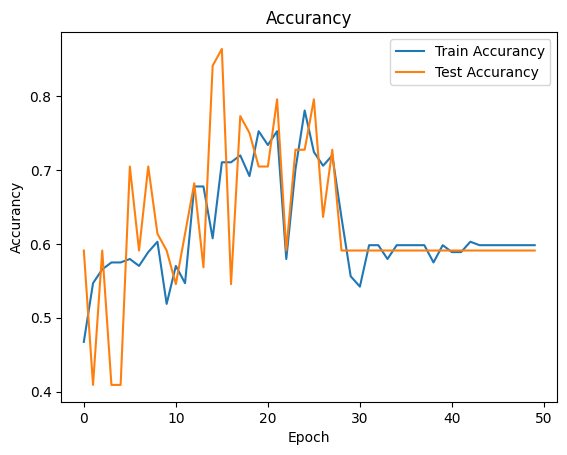

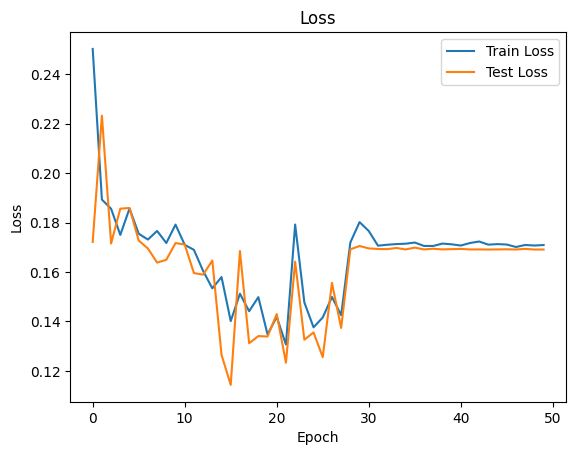

In [3]:
# 判断是否使用GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = SKAttentionSwin_T(num_classes=2)

model = model_ft.to(DEVICE)  # 将模型迁移到gpu

# 优化器
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(DEVICE)  # 将loss_fn迁移到GPU
# Adam损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir=os.path.join('checkpoint', model_name, 'tf_logs'))

def train(epoch):
    model.train()
    correct = 0
    total = 0
    train_acc = 0
    train_loss = 0
    total_loss = 0
    # 开始迭代每个batch中的数据
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        # 计算损失
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # 计算准确率
        train_acc = correct / total
        train_loss = total_loss / total
        # 每训练100个batch打印一次训练集的loss和准确率
        if (batch_idx + 1) % 5 == 0:
            print('Epoch-{}-Batch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f}'.format(epoch + 1,
                                                                                  batch_idx + 1,
                                                                                  train_loss,
                                                                                  train_acc))

    # 计算每个epoch内训练集的acc
    total_train_acc.append(train_acc), total_train_loss.append(train_loss)
    writer.add_scalar('Train/Loss', train_loss, epoch)
    writer.add_scalar('Train/Accuracy', train_acc, epoch)


# Testing
def test(epoch, ckpt):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_acc = 0
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            test_acc = correct / total
            test_loss = total_loss / total
        print(
            'Epoch-{}-Test Accurancy: {:.3f}'.format(epoch + 1, test_acc), '\n')

    total_test_acc.append(test_acc), total_test_loss.append(test_loss)
    writer.add_scalar('Test/Loss', test_loss, epoch)
    writer.add_scalar('Test/Accuracy', test_acc, epoch)

    # 保存权重文件
    acc = 100. * correct / total
    if acc > best_acc:
        print('Saving..')
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        if not os.path.isdir(os.path.join('checkpoint', model_name)):
            os.mkdir(os.path.join('checkpoint', model_name))
        torch.save(model, os.path.join('checkpoint', model_name, model_name + "_" + ckpt))
        best_acc = acc


total_test_acc = []
total_train_acc = []
total_test_loss = []
total_train_loss = []
# 开始训练
epoch = 50
best_acc = 0
for epoch in range(epoch):
    train(epoch)
    test(epoch, "best.pth")
    # 动态调整学习率
    optimizer.step()

writer.close()
plt.figure()
plt.plot(range(epoch + 1), total_train_acc, label='Train Accurancy')
plt.plot(range(epoch + 1), total_test_acc, label='Test Accurancy')
plt.xlabel('Epoch')
plt.ylabel('Accurancy')
plt.title('Accurancy')
plt.legend()
plt.savefig(os.path.join('checkpoint', model_name, f'{model_name}_Accurancy.jpg'))  # 自动保存plot出来的图片

plt.figure()
plt.plot(range(epoch + 1), total_train_loss, label='Train Loss')
plt.plot(range(epoch + 1), total_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.savefig(os.path.join('checkpoint', model_name, f'{model_name}_Loss.jpg'))  # 自动保存plot出来的图片

# 输出best_acc
print(f'Best Acc: {best_acc}%')
